<h1><center>Spaceship Titanic Prediction - Supervised Learning</center></h1>
<center>October 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Dataset
1. Initial Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Missing values
1. EDA
    1. Correlation
    1. Statistical Inference
    1. Distribution
1. Data Preprocessing
1. Feature Selection
    1. All features included
    1. Mutual Information
    1. PCA
1. Models
    1. Baseline model
    1. Basic model
    1. Hyperparameter Tuning
    1. Final Model
    1. Deployment
    1. Model Interpretation
1. Improvements

# 1. Project Introduction

## 1.1. Notebook Preparation

In [74]:
%%capture
%pip install -r requirements.txt

In [75]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.eda import *
from utils.model import *
from utils.stats import *
from scipy.stats import mannwhitneyu

from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import (KFold, cross_val_score)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, 
                                   FunctionTransformer, OrdinalEncoder,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, roc_curve, auc, 
                             make_scorer)
import graphviz
import shap
import optuna
import pickle

## 1.2. Dataset

Objective: Brief overview of our dataset, including the features and target 
variable

The dataset was downloaded from Kaggle, [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv)
, on 18 October 2024. <br>
This dataset is part of an open Kaggle competition, 
where the task is to predict whether a passenger was transported to an 
alternate dimension during the Spaceship Titanic's collision with the 
spacetime anomaly. <br>
The data originally comes in 2 separate datasets, *train.csv* and *test.csv*
. Each dataset contains a set of personal records recovered from the ship's
 damaged computer system. There are 13 columns of personal records, and the 
 14th column is the target.

- train.csv - Personal records for about two-thirds (~8700) of the 
passengers, to be used as training data.
- test.csv - Personal records for the remaining one-third (~4300) of the 
passengers, to be used as test data. Does not include the target variable. 
My task is to predict the value of Transported for the passengers in this set.
<ol>
<li>PassengerId - A unique Id for each passenger. Each Id takes the form 
gggg_pp where gggg indicates a group the passenger is travelling with and pp
 is their number within the group. People in a group are often family 
 members, but not always.</li>
<li>HomePlanet - The planet the passenger departed from, typically their planet
 of permanent residence.</li>
<li>CryoSleep - Indicates whether the passenger elected to be put into 
suspended animation for the duration of the voyage. Passengers in cryosleep 
are confined to their cabins.</li>
<li>Cabin - The cabin number where the passenger is staying. Takes the form 
deck/num/side, where side can be either P for Port or S for Starboard.</li>
<li>Destination - The planet the passenger will be debarking to.</li>
<li>Age - The age of the passenger.</li>
<li>VIP - Whether the passenger has paid for special VIP service during the 
voyage.</li>
<li>RoomService - Amount the passenger has billed at this luxury amenity. </li>
<li>FoodCourt - Amount the passenger has billed at this luxury amenity. </li>
<li>ShoppingMall - Amount the passenger has billed at this luxury amenity. </li>
<li>Spa - Amount the passenger has billed at this luxury amenity. </li>
<li>VRDeck - Amount the passenger has billed at this luxury amenity. </li>
<li>Name - The first and last names of the passenger.</li>
<li>Transported - Whether the passenger was transported to another dimension. 
This is the target, the column I am trying to predict.</li>
</ol>

In [76]:
spaceship_train = pd.read_csv('data/train.csv')
display(spaceship_train.head())
spaceship_train_shape = spaceship_train.shape
print(f"Number of rows on train data: {spaceship_train_shape[0]}\nNumber of "
      f"columns on train data: {spaceship_train_shape[1]}")

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

Number of rows on train data: 8693
Number of columns on train data: 14


# 2. Initial Data cleaning
Objective:
1. Closer look at the values that consist of our data
2. Look out for duplicates, and missing and/or unusual values

## 2.1. Duplicate rows

In [77]:
print(spaceship_train['PassengerId'].duplicated().any())

False


## 2.2. Datatypes

In [78]:
spaceship_train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In our feature columns, there is only 'object' and 'float' datatypes, the 
target variable is in 'bool'.

## 2.3. Missing values

In [79]:
print(spaceship_train.isnull().sum().sum())

2324


In [80]:
missing_values(df=spaceship_train)

Missing Values  Percentage Missing
PassengerId                0                0.00
HomePlanet               201                2.31
CryoSleep                217                2.50
Cabin                    199                2.29
Destination              182                2.09
Age                      179                2.06
VIP                      203                2.34
RoomService              181                2.08
FoodCourt                183                2.11
ShoppingMall             208                2.39
Spa                      183                2.11
VRDeck                   188                2.16
Name                     200                2.30
Transported                0                0.00

There is missing values all over the dataset, except for PassengerId and the
 target variable. The amount of missing value is also quite similar across 
 all features, numbers ranging around 200.

## 2.4. Values

Brief overview of the overall distribution for numerical features, the 
values itself for the rest.

In [81]:
spaceship_train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

The range of values is very different when comparing 'Age' to other 
features, but not their interquartile range (IQR). <br>
Also notice that the median value for these other features are 0, regardless
 of their maximum value. This is indicating outliers with extreme values. 

In [82]:
spaceship_train.describe(include=['object', 'bool'])

PassengerId HomePlanet CryoSleep    Cabin  Destination    VIP  \
count         8693       8492      8476     8494         8511   8490   
unique        8693          3         2     6560            3      2   
top        0001_01      Earth     False  G/734/S  TRAPPIST-1e  False   
freq             1       4602      5439        8         5915   8291   

                  Name Transported  
count             8493        8693  
unique            8473           2  
top     Gollux Reedall        True  
freq                 2        4378

Looking into the values, these categorical features fit into several types of 
categories. 
<br>
1. PassengerId, Cabin, Name: features containing many unique values. Could 
contain multiple information, which could be extracted.
2. HomePlanet, Destination: Nominal features 
3. CyroSleep, VIP, Transported: True/False values. Boolean variable

The target variable, Transported, is well divided between 2 classes, our 
dataset does NOT have imbalance issues.

**PassengerID, Name, Cabin**<br>

PassengerId contains useful information like whether a passenger belonged to
 a group, and the group size.

In [83]:
spaceship_train['Group'] = spaceship_train['PassengerId'].apply(lambda x: x.split('_')[0])
spaceship_train['GroupSize'] = spaceship_train.groupby('Group')['Group'].transform('count')
spaceship_train['InGroup'] = spaceship_train['GroupSize'] > 1

spaceship_train[['Group', 'GroupSize', 'InGroup']].head()

Group  GroupSize  InGroup
0  0001          1    False
1  0002          1    False
2  0003          2     True
3  0003          2     True
4  0004          1    False

There is no relevant information in the passenger's names.

In [84]:
spaceship_train = spaceship_train.drop(['Name'], axis=1)

Cabin can be broken down into 3 features, deck, num, side

In [85]:
spaceship_train[['Deck', 'Num', 'Side']] = spaceship_train['Cabin'].str.split('/', expand=True)
spaceship_train[['Cabin', 'Deck', 'Num', 'Side']].head()

Cabin Deck Num Side
0  B/0/P    B   0    P
1  F/0/S    F   0    S
2  A/0/S    A   0    S
3  A/0/S    A   0    S
4  F/1/S    F   1    S

# 3. EDA

## 3.1. Correlation
Objective:<br>
1. Correlations between features
2. Correlations between features and target

**Correlation between features**

In [86]:
spaceship_eda = spaceship_train.copy()

target_name = 'Transported'
data, target = (spaceship_eda.drop(columns=[target_name]), 
                spaceship_eda[target_name])

PassengerId and Cabin are not needed as their information is extracted to 
new columns.<br>
Separate the rest of the columns for correlation purposes.

In [87]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 
                     'Spa', 'VRDeck']
ordinal_yesno_columns = ['CryoSleep', 'VIP', 'InGroup', 'GroupSize',
                        'Num', 'Deck', 'Side']
multicat_columns = ['HomePlanet', 'Destination', 'Group']

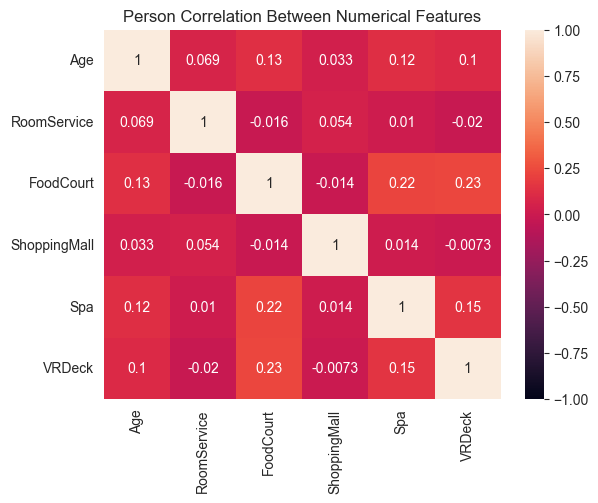

In [88]:
corr = spaceship_eda[numerical_columns].corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Person Correlation Between Numerical Features')
plt.show()

All numerical features are weakly linearly correlated, it is not enough 
to cause any issues in our models. <br>
The most significant finding is between FoodCourt and VRDeck or Spa. There 
is also other correlations between luxury amenities spending, which is 
expected as it is there could be other confounding factors like income.

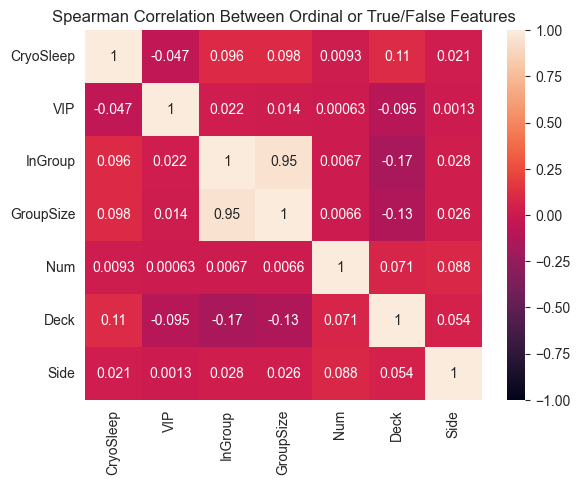

In [89]:
le = LabelEncoder()
for col in ordinal_yesno_columns:
    spaceship_eda[col] = le.fit_transform(spaceship_eda[col].astype(str))

corr = spaceship_eda[ordinal_yesno_columns].corr('spearman')
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Ordinal or True/False Features')
plt.show()

Looking into the monotonic relationships between ordinal or 
True/False features, we see most are extremely weak.<br>
The exceptions found are between InGroup, GroupSize, and Deck. The 
correlation between InGroup and GroupSize is very strong and also clearly 
due to the fact that all passengers without a group, have groupsize=1.

In [90]:
cramers_v_results = {}
for col1 in multicat_columns:
    for col2 in multicat_columns:
        if col1 != col2:
            cramers_v_results[(col1, col2)] = cramers_v(spaceship_eda[col1],
                                                        spaceship_eda[col2])

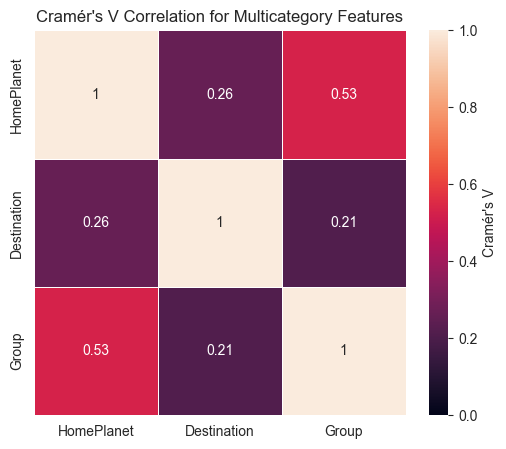

In [91]:
heatmap_matrix = np.ones((len(multicat_columns), len(multicat_columns)))

for (cat1, cat2), value in cramers_v_results.items():
    i, j = multicat_columns.index(cat1), multicat_columns.index(cat2)
    heatmap_matrix[i, j] = value
    heatmap_matrix[j, i] = value

heatmap_df = pd.DataFrame(heatmap_matrix, index=multicat_columns, 
                          columns=multicat_columns)

plt.figure(figsize=(6, 5))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            linewidths=0.5, cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation for Multicategory Features")
plt.show()

HomePlanet is moderate to strongly correlated with Group. Other features are
 weak to moderately correlated, the dataset can benefit from some feature 
 selection before applying machine learning models.

**Correlation features vs target**

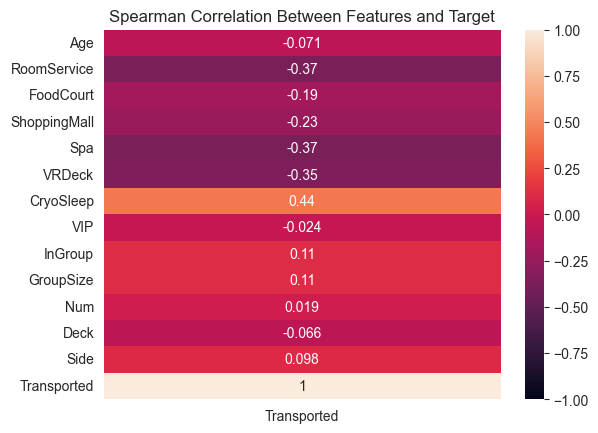

In [92]:
columns = numerical_columns + ordinal_yesno_columns + [target_name]

corr = spaceship_eda[columns].corr('spearman')[[target_name]]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Features and Target')
plt.show()

In [93]:
cramers_v_results = {}
for col1 in multicat_columns:
        cramers_v_results[col1] = (
            cramers_v(spaceship_eda[col1],spaceship_eda[target_name])
        )

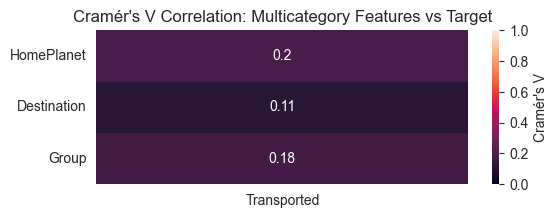

In [94]:
heatmap_df = pd.DataFrame(cramers_v_results, index=[target_name]).T

plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation: Multicategory Features vs Target")
plt.show()

Features vs Target:<br>
1. In the Spearman's correlation, 'CryoSleep' has the best correlation found
. 'Age', 'VIP', 'Deck', 'Num', and 'Side' have 
extremely low values. While all luxury amenities are low to moderately 
correlated with the target variable. <br>
2. Values between Spearman's correlation and Cramers V correlation are not 
directly comparable. However, the multicategorical features, like luxury 
amenities, are weak to moderately correlated with the target variable. <br><br>

Important to consider that the features low to moderately correlated with 
target variable, luxury amenities and multicategory, also show some level
 of correlation between themselves. However, interestingly the best 
 correlated feature, 'CryoSleep', did not show correlations with other 
 ordinal/binary features.<br>
 
It would be relevant to check if 'CryoSleep' were correlated with luxury 
amenities and multicategorical features. Also, if correlations were 
statistically significant.

**Correlation - CryoSleep and other features**

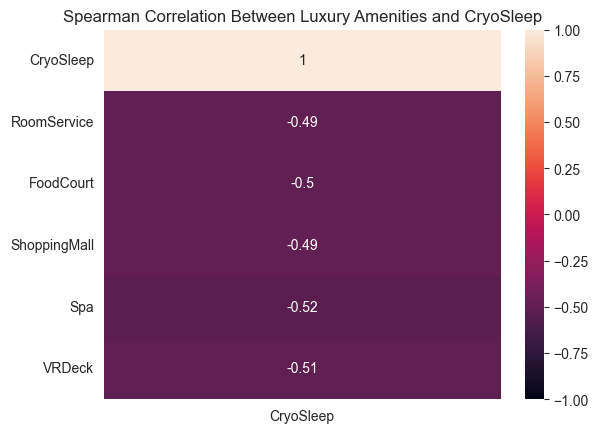

In [95]:
columns = ['CryoSleep', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
           'VRDeck']

corr = spaceship_eda[columns].corr('spearman')[['CryoSleep']]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Luxury Amenities and CryoSleep')
plt.show()

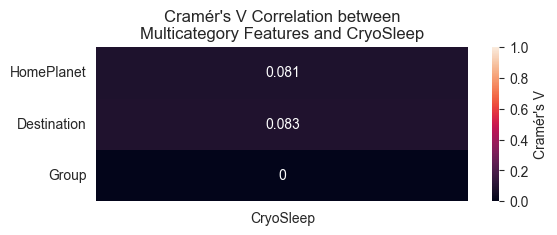

In [96]:
cramers_v_results = {}
for col1 in multicat_columns:
        cramers_v_results[col1] = (
            cramers_v(spaceship_eda[col1],spaceship_eda['CryoSleep'])
        )
        
heatmap_df = pd.DataFrame(cramers_v_results, index=['CryoSleep']).T

plt.figure(figsize=(6, 2))
sns.heatmap(heatmap_df, annot=True, vmin=0, vmax=1,
            cbar_kws={"label": "Cramér's V"})
plt.title("Cramér's V Correlation between\nMulticategory Features and "
          "CryoSleep")
plt.show()

CryoSleep shows negligible correlations with multicatgory features, and 
moderate to strong correlations with all luxury amenity features as 
expected, as passengers in CryoSleep cannot leave their cabin. <br>
The following will show the true correlation between amenities spending and 
whether they were transported.

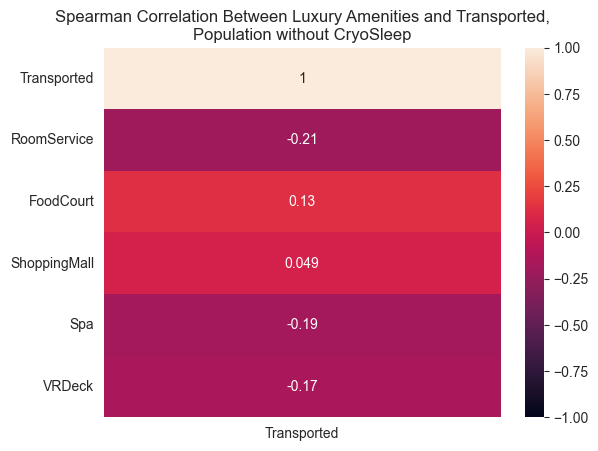

In [97]:
columns = ['Transported', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 
           'VRDeck']
df = spaceship_eda[columns][spaceship_eda.CryoSleep==False]

corr = df.corr('spearman')[['Transported']]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Spearman Correlation Between Luxury Amenities and '
          'Transported,\nPopulation without CryoSleep')
plt.show()

In [98]:
HTML('''
<div class="alert alert-block alert-info">
    <b>Correlation between features Insights:</b><br>
    After calculating correlations between the same type of data - 
    numerical, bianry, ordinal, multicategorical. Most correlation 
    coefficients are weak, which should not cause issues in ML. The 
    following several features were exceptions showing moderate correlation 
    coefficients: <br>
    1. FoodCourt and VRDeck or Spa <br>
    2. InGroup, GroupSize, and Deck <br>
    3. HomePlanet, Destination, Group<br><br>
    
    <b>Correlation between features and target Insights:</b><br>
    1. 'Age', 'VIP', 'Deck', 'Num', and 'Side' have extremely low values.<br>
    2. 'CryoSleep' has the best correlation. <br>
    3. All multicategorical features and luxury amenities are low to 
    moderately correlated. Note that these feature also showed correlation 
    between themselves.<br><br>
    
    <b>Correlation between CryoSleep and other features Insights:</b><br>
    1. Negligible correlations with multicatgory features. <br>
    2. Moderate to strong correlations with all luxury amenity features. But
     when considering only population who did not use CryoSleep, the 
     correlations dropped to weak.
</div>
''')

## 3.2. Statistical Inference
Objective: <br>
1. Check statistical significance between multicategorical features and 
target variable.
2. Check statistical significance between 'CryoSleep' and target variable.
3. Check statistical significance between luxury amenities and target variable.

Chi-Square Test

**Population:** all passengers with known values. <br>
**Null Hypothesis:** feature and target are independent. All groups are 
equally likely to be transported.<br>
**Alternative Hypothesis:** feature and target are dependent. At least one of 
the groups are less or more likely to be transported.

In [99]:
contingency_table_homeplanet = pd.crosstab(spaceship_train['HomePlanet'], 
                                spaceship_train['Transported'])
contingency_table_destination = pd.crosstab(spaceship_train['Destination'], 
                                        spaceship_train['Transported'])
contingency_table_group = pd.crosstab(spaceship_train['Group'], 
                                  spaceship_train['Transported'])
contingency_table_cryosleep = pd.crosstab(spaceship_train['CryoSleep'], 
                                          spaceship_train['Transported'])

In [100]:
contingency_table_homeplanet

Transported  False  True 
HomePlanet               
Earth         2651   1951
Europa         727   1404
Mars           839    920

In [101]:
contingency_table_destination

Transported    False  True 
Destination                
55 Cancri e      702   1098
PSO J318.5-22    395    401
TRAPPIST-1e     3128   2787

In [102]:
contingency_table_group

Transported  False  True 
Group                    
0001             1      0
0002             0      1
0003             2      0
0004             0      1
0005             0      1
...            ...    ...
9275             1      2
9276             1      0
9278             1      0
9279             0      1
9280             1      1

[6217 rows x 2 columns]

In [103]:
contingency_table_cryosleep

Transported  False  True 
CryoSleep                
False         3650   1789
True           554   2483

In [104]:
chi_square_results = {col: chi_square_test(spaceship_train, col, target_name) 
                      for col in multicat_columns}
chi_square_results['CryoSleep'] = chi_square_test(
    spaceship_train, 'CryoSleep', target_name)
chi_square_df = pd.DataFrame(list(chi_square_results.items()), 
                             columns=['Feature', 'Chi-square p-value'])
chi_square_df

Feature  Chi-square p-value
0   HomePlanet        2.809060e-71
1  Destination        7.892901e-24
2        Group        6.870372e-03
3    CryoSleep        0.000000e+00

All our p-values are <0.05, and very close to 0. This rejects the null 
hypothesis it tells us these features contain relevant information for our 
predictive model.<br>
1. Most who travelled from Earth were less likely to be transported, and 
from Europa were more likely.
2. Most whose destination were 55 Cancri e were more likely to be transported.
3. Most who were in CryoSleep were more likely to be transported.
4. Group had the highest p value of all, while still rejecting the null 
hypothesis. However, this feature contains many unique values and might not 
be actually that relevant for the model, just like PassengerId.

Mann-Whitney U test

**Population:** all passengers with known values, and were not in CryoSleep. 
<br>
**Null Hypothesis:** The distributions of the two groups (Transported = 0 and Transported = 1) are the same.<br>
**Alternative Hypothesis:** The distributions of the two groups are different.

In [105]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df = spaceship_eda[spaceship_eda.CryoSleep==False]
stat_results = []
for col in columns:
    group0 = df[df[target_name] == 0][col].dropna()
    group1 = df[df[target_name] == 1][col].dropna()
    
    mw_stat, mw_pval = mannwhitneyu(group0, group1)
    
    stat_results.append({
        'Feature': col,
        'Mann-Whitney p-value': mw_pval
    })

stat_results_df = pd.DataFrame(stat_results)
stat_results_df

Feature  Mann-Whitney p-value
0   RoomService          1.929674e-51
1     FoodCourt          6.314324e-21
2  ShoppingMall          3.856329e-04
3           Spa          7.494035e-46
4        VRDeck          1.631125e-35

Despite the correlation coefficients for luxury amenities had reduced 
significantly after removing passengers in CryoSleep, the statistical tests 
still show there are significant differences between passengers with 
different amenities spending habits.

## 3.3. Distribution

Drop columns PassengerId, Cabin, Group, and Num as they have a large amount of 
unqiue values, not suitable for visualization.

In [106]:
categorical_columns_selector = selector(dtype_exclude='number')
numerical_columns_selector = selector(dtype_include='number')

categorical_columns = categorical_columns_selector(data)
categorical_columns.remove('PassengerId')
categorical_columns.remove('Cabin')
categorical_columns.remove('Group')
categorical_columns.remove('Num')
numerical_columns = numerical_columns_selector(data)

**Numerical Features**

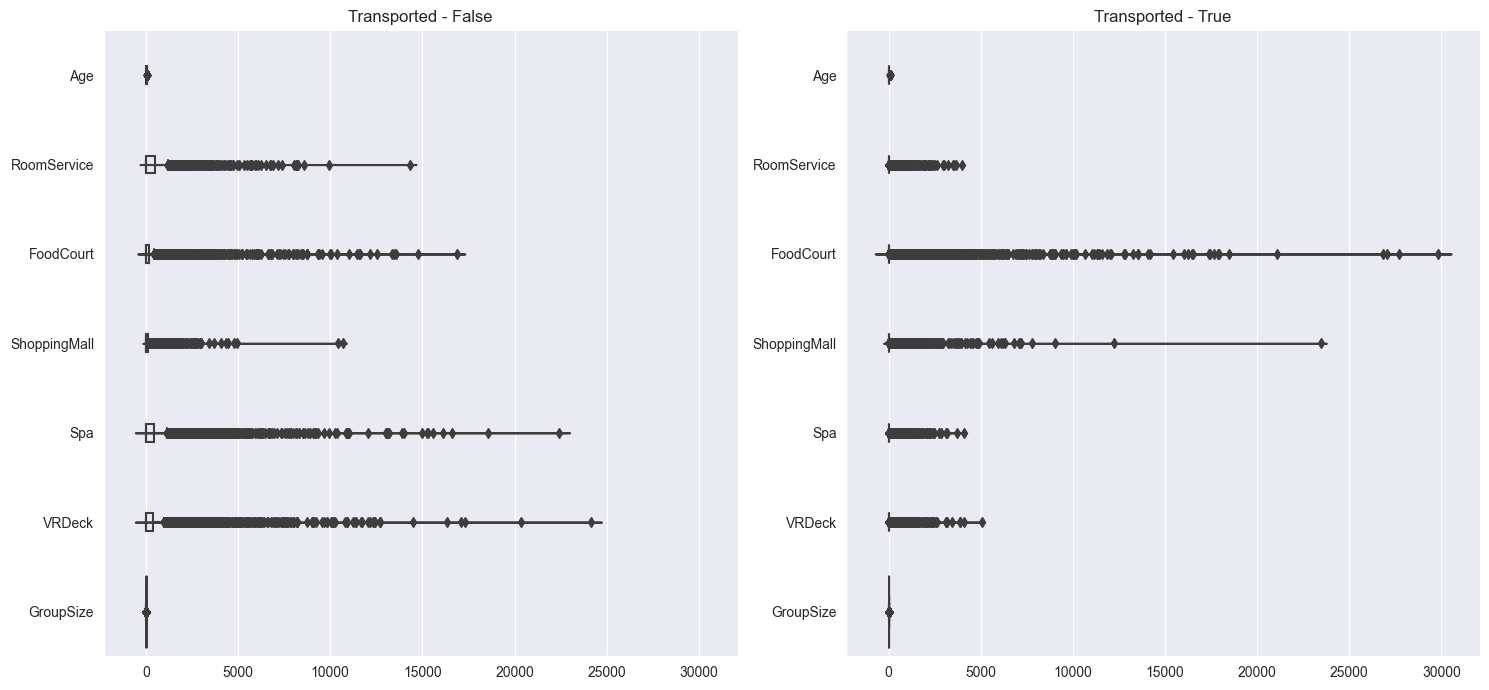

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=True)

violin_boxplot(data=spaceship_train[spaceship_train.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[1])
violin_boxplot(data=spaceship_train[spaceship_train.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[0])

plt.tight_layout()
plt.show()

Taking a closer look at the plots.

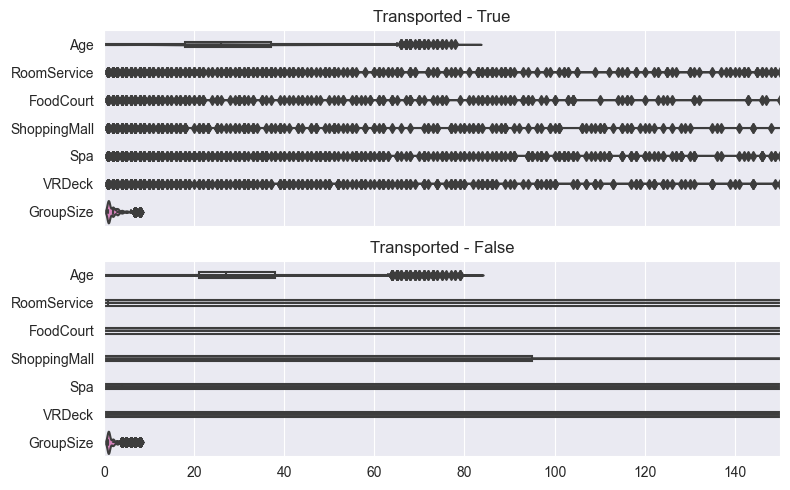

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)

violin_boxplot(data=spaceship_train[spaceship_train.Transported == True], 
               columns=numerical_columns, title='Transported - True', 
               ax=axes[0])
violin_boxplot(data=spaceship_train[spaceship_train.Transported == False], 
               columns=numerical_columns, title='Transported - False', 
               ax=axes[1])

axes[1].set_xlim(0, 150)
axes[0].set_xlim(0, 150)
plt.tight_layout()
plt.show()

In [109]:
spaceship_train[spaceship_train.Transported==True].describe()

Age  RoomService     FoodCourt  ShoppingMall          Spa  \
count  4288.000000  4295.000000   4279.000000   4264.000000  4287.000000   
mean     27.748834    63.098021    532.691984    179.829972    61.675531   
std      15.151705   274.812497   1931.306995    722.026714   262.682871   
min       0.000000     0.000000      0.000000      0.000000     0.000000   
25%      18.000000     0.000000      0.000000      0.000000     0.000000   
50%      26.000000     0.000000      0.000000      0.000000     0.000000   
75%      37.000000     0.000000      0.000000      0.000000     0.000000   
max      78.000000  3992.000000  29813.000000  23492.000000  4103.000000   

            VRDeck    GroupSize  
count  4280.000000  4378.000000  
mean     69.148131     2.166514  
std     291.658171     1.616655  
min       0.000000     1.000000  
25%       0.000000     1.000000  
50%       0.000000     2.000000  
75%       0.000000     3.000000  
max    5063.000000     8.000000

In [110]:
spaceship_train[spaceship_train.Transported==False].describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4226.000000   4217.000000   4231.000000   4221.000000   4223.000000   
mean     29.922858    389.266066    382.615930    167.566217    564.382666   
std      13.699262    875.638123   1200.115601    456.528126   1551.356047   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      21.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      1.000000      0.000000      0.000000      4.000000   
75%      38.000000    473.000000    179.000000     95.000000    453.500000   
max      79.000000  14327.000000  16856.000000  10705.000000  22408.000000   

             VRDeck    GroupSize  
count   4225.000000  4315.000000  
mean     543.629822     1.902665  
std     1563.088368     1.564494  
min        0.000000     1.000000  
25%        0.000000     1.000000  
50%        1.000000     1.000000  
75%      388.000000     2.000000  
max    24133.000000     8.000000

Notice all luxury amenities spending features display median 
values close to 0. When taken into account the whole IQR, people who were NOT 
 transported, had higher amenities spending, confirming the findings from 
 correlations.

**Categorical Features - without PassengerID, Name, Cabin**

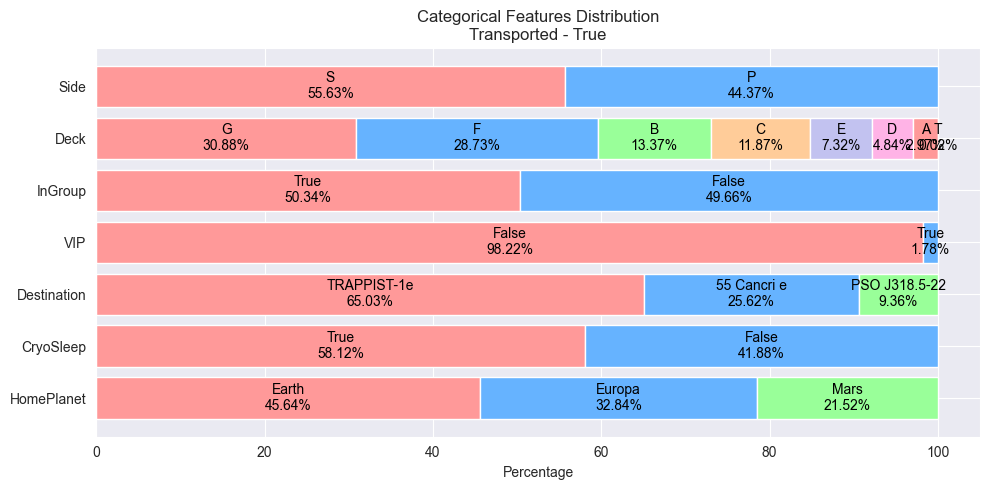

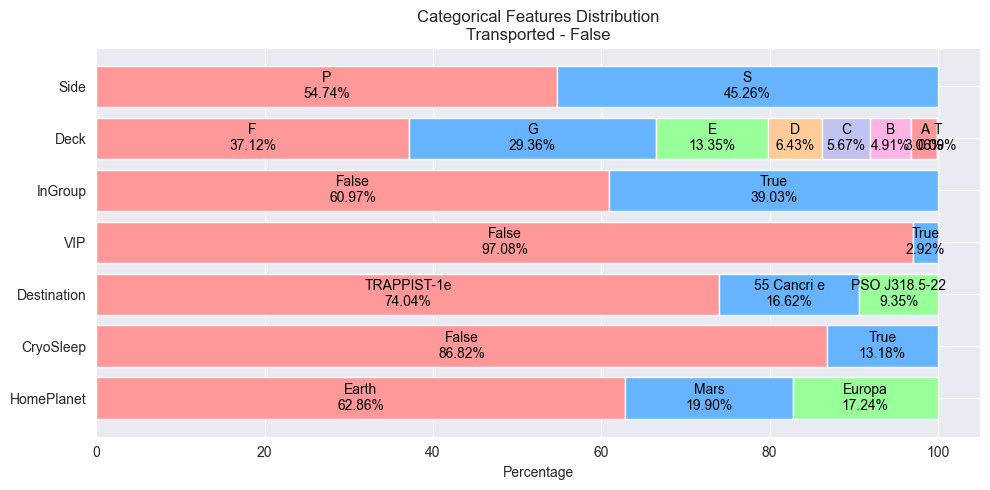

In [111]:
stacked_horizontal_feature_distribution(
    data=spaceship_train[spaceship_train.Transported == True], 
    columns=categorical_columns, 
    title='Categorical Features Distribution\nTransported - True') 

stacked_horizontal_feature_distribution(
    data=spaceship_train[spaceship_train.Transported == False], 
    columns=categorical_columns,
    title='Categorical Features Distribution\nTransported - False')

The distributions in general are coherent with what was observed at Data 
Cleaning and correlations.<br> 
There are some differences between the target labels, mainly at the 
numerical features, 'HomePlanet', 'Destination', and in the feature 
'CyroSleep'. <br>

# 4. Data Preprocessing

Separate data and target

In [112]:
spaceship_ml = spaceship_train.copy()
spaceship_ml = spaceship_ml.drop(['PassengerId', 'Cabin', 'Group', 'Num'], 
                                 axis=1)

X, y = (spaceship_ml.drop(columns=[target_name]).copy().reset_index(drop=True), 
            spaceship_ml[target_name].reset_index(drop=True))

**Define columns**<br>
Remove columns that do not contain relevant information for ML

In [113]:
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 
                     'Spa', 'VRDeck']
ordinal_yesno_columns = ['CryoSleep', 'VIP', 'InGroup', 'GroupSize', 'Side']
multicat_columns = ['HomePlanet', 'Destination', 'Deck']


for col in ordinal_yesno_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

**Define preprocessors for each data type**

In [114]:
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OrdinalEncoder())
])

multicat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))
])

**Bundle preprocessors for all data**

In [115]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('ord', ordinal_pipeline, ordinal_yesno_columns),
        ('cat', multicat_pipeline, multicat_columns),
    ]
)

In [116]:
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_1)
])

# 5. Feature Selection
Objective:<br>
1. Baseline model - no feature selection
2. Feature selection by mutual information and PCA

## 5.1. All features included

/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.3.5/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



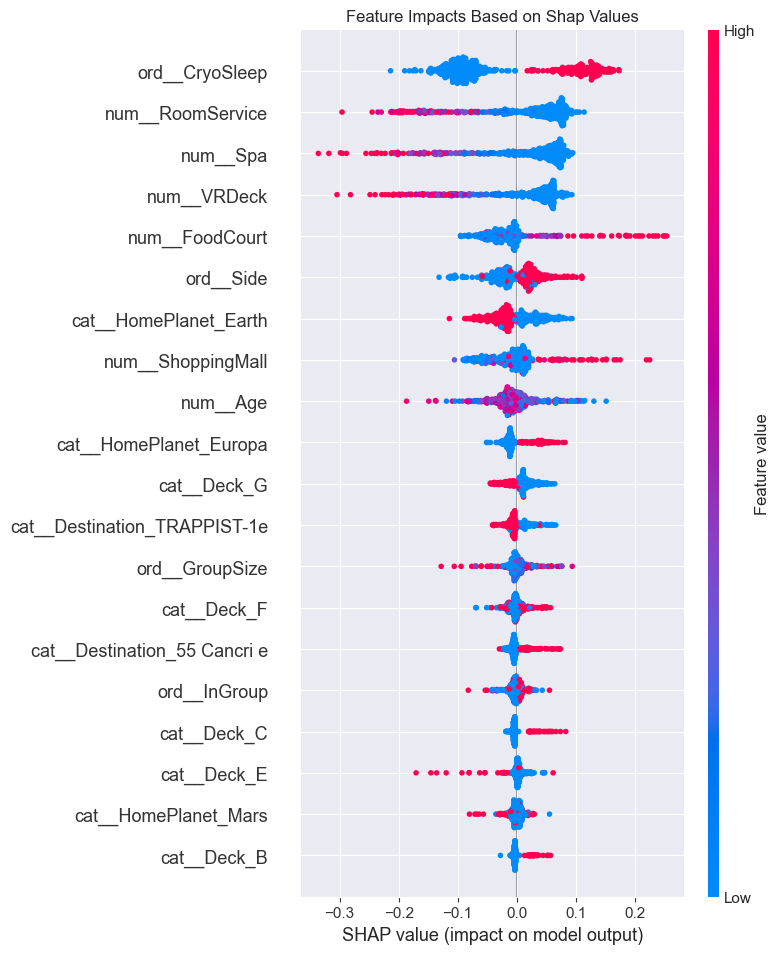

In [117]:
X_train_tf, y_train, X_eval_tf, y_eval = (prep_train_eval(preprocessor_1, X,
                                                          y))

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_tf, y_train)

shap.initjs()
observations = X_eval_tf.sample(500, random_state=0)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(observations)
shap.summary_plot(shap_vals[1], observations, show=False)

plt.title("Feature Impacts Based on Shap Values")
plt.show()

In [118]:
y_pred = model.predict(X_eval_tf)
y_pred_proba = model.predict_proba(X_eval_tf)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

accuracy   roc_auc  precision    recall        f1
Evaluation  0.788959  0.866143   0.807739  0.762557  0.784498

## 5.2. Mutual Information

In [119]:
mi_scores = mutual_info_classif(X_train_tf, y_train, 
                                discrete_features='auto', random_state=0)
mi_df = pd.DataFrame({'Feature': X_train_tf.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

mi_df

Feature  Mutual Information
6                   ord__CryoSleep            0.119202
1                 num__RoomService            0.069291
5                      num__VRDeck            0.067586
4                         num__Spa            0.061921
3                num__ShoppingMall            0.056176
2                   num__FoodCourt            0.036489
18                     cat__Deck_B            0.023453
12          cat__HomePlanet_Europa            0.018490
0                         num__Age            0.015427
21                     cat__Deck_E            0.014912
10                       ord__Side            0.014263
19                     cat__Deck_C            0.013668
16    cat__Destination_TRAPPIST-1e            0.013395
14    cat__Destination_55 Cancri e            0.010411
9                   ord__GroupSize            0.009994
7                         ord__VIP            0.009775
11           cat__HomePlanet_Earth            0.008503
20                     cat__Deck_D            0.002515
22                     cat__Deck_F            0.001164
8                     ord__InGroup            0.000993
13            cat__HomePlanet_Mars            0.000000
15  cat__Destination_PSO J318.5-22            0.000000
17                     cat__Deck_A            0.000000
23                     cat__Deck_G            0.000000
24                     cat__Deck_T            0.000000

Unsurprisingly, features when ordered by mutual information, CryoSleep is 
the first. Followed by all the luxury amenities spending.<br> 
The features with top 10 importance were the following:<br>
1. ord__CryoSleep
2. num__RoomService
3. num__VRDeck
4. num__Spa
5. num__ShoppingMall
6. num__FoodCourt
7. cat__Deck_B
8. cat__HomePlanet_Europa
9. ord__Side
10. num__Age

In [120]:
selected_features_threshold = (
    mi_df[mi_df['Mutual Information'] > 0.01]['Feature'].tolist())
print("Selected Features (Threshold > 0.01):", selected_features_threshold)

Selected Features (Threshold > 0.01): ['ord__CryoSleep', 'num__RoomService', 'num__VRDeck', 'num__Spa', 'num__ShoppingMall', 'num__FoodCourt', 'cat__Deck_B', 'cat__HomePlanet_Europa', 'num__Age', 'cat__Deck_E', 'ord__Side', 'cat__Deck_C', 'cat__Destination_TRAPPIST-1e', 'cat__Destination_55 Cancri e']


In [121]:
X_eval_tf_mi = X_eval_tf.copy()
X_eval_tf_mi = X_eval_tf_mi[selected_features_threshold]

X_train_tf_mi = X_train_tf.copy()
X_train_tf_mi = X_train_tf_mi[selected_features_threshold]

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_tf_mi, y_train)

RandomForestClassifier(random_state=0)

In [122]:
y_pred = model.predict(X_eval_tf_mi)
y_pred_proba = model.predict_proba(X_eval_tf_mi)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

accuracy   roc_auc  precision    recall        f1
Evaluation  0.782059  0.855781   0.778275  0.793379  0.785755

## 5.3. PCA

By setting n_components=0.95, PCA keeps enough components to explain 95% of 
the variance.

In [123]:
n_components = 0.95
pca = PCA(n_components=n_components, random_state=0)

X_train_pca = pca.fit_transform(X_train_tf)
X_eval_pca = pca.transform(X_eval_tf)

X_pca_df = pd.DataFrame(X_train_pca,
                        columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.897907  8.559350 -0.495101  0.877916  0.434959 -9.054295 -5.836510   
1 -1.035533 -0.501486 -0.413108  0.128926  0.504027 -0.684964 -0.153306   
2  0.732625  0.164739  2.266308 -1.737036 -0.338585  0.343947 -0.113313   
3 -1.092004  0.154557  0.240113  0.611833  0.442060 -1.312529 -0.513283   
4  0.258828 -0.155946 -0.522418 -0.052894 -0.235367  0.054520  0.112240   

        PC8       PC9      PC10      PC11      PC12      PC13  
0  0.165638  0.650334 -0.562067  0.428079  1.042786  0.025462  
1  0.174506 -0.762726 -0.378726 -0.446294 -0.410534  0.280537  
2 -0.129237 -0.578963 -0.189045  0.504197  0.303470  0.038514  
3  0.306185 -0.602147 -0.363024  0.563309 -0.229846  0.312591  
4 -1.315865  1.136607 -0.137908  0.413708 -0.284526  0.177867

In [124]:
variance_explained = pca.explained_variance_ratio_
total_variance_explained = variance_explained.sum()

print("Variance Explained by Each Component:", variance_explained)
print("Total Variance Explained:", total_variance_explained)

Variance Explained by Each Component: [0.2474777  0.14567678 0.10128053 0.0868755  0.07782662 0.07577706
 0.06917756 0.03781621 0.03476255 0.02613902 0.02244932 0.01582494
 0.01327574]
Total Variance Explained: 0.9543595350837145


In [125]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_eval_pca)
y_pred_proba = model.predict_proba(X_eval_pca)[:, 1]

evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

accuracy   roc_auc  precision    recall        f1
Evaluation  0.775733  0.860255   0.792771  0.751142  0.771395

**Feature Selection Insights:**<br>
    Comparing feature selection using PCA, simple 
    Mutual Information, and whole dataset without feature selection. It is 
    clear the metric scores were similar between all. Therefor, PCA will not
     be used for now, as it would make our model harder to interpret without
      much benefits.

# 6. Models
Objective:<br>
1. Apply and hyperparameter tuning machine learning models
2. Assess and select the best model

## 6.1. Baseline Model

As our dataset is balanced, it is adequate to use stratified strategy. The 
dummy classifier will randomly predict a class label for each sample, while 
maintaining the same class distribution as in the training data.

In [126]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train_tf_mi, y_train)

y_dummy_pred = dummy_clf.predict(X_eval_tf_mi)
y_pred_proba = dummy_clf.predict_proba(X_eval_tf_mi)[:, 1]
evaluation_metrics = {
    'accuracy': accuracy_score(y_eval, y_pred),
    'roc_auc': roc_auc_score(y_eval, y_pred_proba),
    'precision': precision_score(y_eval, y_pred, zero_division=0),
    'recall': recall_score(y_eval, y_pred, zero_division=0),
    'f1': f1_score(y_eval, y_pred, zero_division=0)
}

evaluation_df = pd.DataFrame(evaluation_metrics, index=['Evaluation'])
evaluation_df

accuracy   roc_auc  precision    recall        f1
Evaluation  0.775733  0.518641   0.792771  0.751142  0.771395

## 6.2. Basic Model
Objective: Fit, evaluate and pick the model to work on.

**Models**

1. Logistic Regression
2. Random forest classifier
2. XGBoost gradient boosted trees
3. LightGBM histogram gradient boosting

In [127]:
log_reg = LogisticRegression(random_state=0)
random_forest = RandomForestClassifier(random_state=0)
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=0)
clf_lgb = lgb.LGBMClassifier(objective='binary', random_state=0)

**Pipeline**

In [128]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
feature_selector = SelectKBest(mutual_info_classif,
                               k=len(selected_features_threshold))

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', clf_xgb)
])

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', clf_lgb)
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('feature_selection', feature_selector),
    ('classifier', log_reg)
])

**Cross Validation**

*Primary Metric: Accuracy*<br>
The dataset is balanced and our problem does not have a specific focus on 
types of errors, so accuracy will be a straightforward measure of the 
model’s success in classifying the correct destination. <br><br>
*Secondary Metric: ROC AUC and F1 Score*<br>
1. ROC AUC: This will show how well the model distinguishes between 
Transported or not.
2. F1 Score: Provides a balanced view of precision and recall, ensuring
that each class is handled reasonably well in terms of both capturing and 
not over-predicting each class.


In [129]:
models = {
    "Random Forest": pipeline_rf,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgb,
    "Logistic Regression": pipeline_lr
}

thresholds_range = np.linspace(0, 1, 101)
model_results = {model_name: [] for model_name in models.keys()} 

Perform cross-validation and collect mean scores for each threshold 

In [130]:
thresholds_range = np.linspace(0, 1, 101)
standard_fpr = np.linspace(0, 1, 100)

# Initialize dictionary for model results if not done previously
model_results = {}

for model_name, pipeline in models.items():
    print(f"Evaluating {model_name}")
    
    # Initialize lists for each fold
    fprs, tprs, accuracies, f1s = [], [], [], [] 
    
    # Cross-validation loop
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
        
        # Interpolate TPR at standard FPR points
        interp_tpr = np.interp(standard_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # Ensuring the curve starts at (0,0)
        
        # Append the FPR and interpolated TPR for this fold
        fprs.append(standard_fpr)
        tprs.append(interp_tpr)
        
        # Calculate Accuracy and F1 Score at multiple thresholds
        fold_accuracy, fold_f1 = [], []
        for threshold in thresholds_range:
            y_pred = (y_proba >= threshold).astype(int)
            fold_accuracy.append(accuracy_score(y_test, y_pred))
            fold_f1.append(f1_score(y_test, y_pred, zero_division=0))
        
        accuracies.append(fold_accuracy)
        f1s.append(fold_f1)

    # Calculate mean TPR, FPR, Accuracy, and F1 across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_fpr = standard_fpr  # standard FPR range
    mean_accuracy = np.mean(accuracies, axis=0)
    mean_f1 = np.mean(f1s, axis=0)
    
    # Calculate AUC based on mean TPR and FPR
    auc_score = auc(mean_fpr, mean_tpr)
    
    # Store results
    model_results[model_name] = {
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "mean_accuracy": mean_accuracy,
        "mean_f1": mean_f1,
        "auc_score": auc_score
    }


Evaluating Random Forest
Evaluating XGBoost
Evaluating LightGBM
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3506, number of negative: 3448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

Plotting Accuracy vs Threshold and F1 score vs Threshold for each model

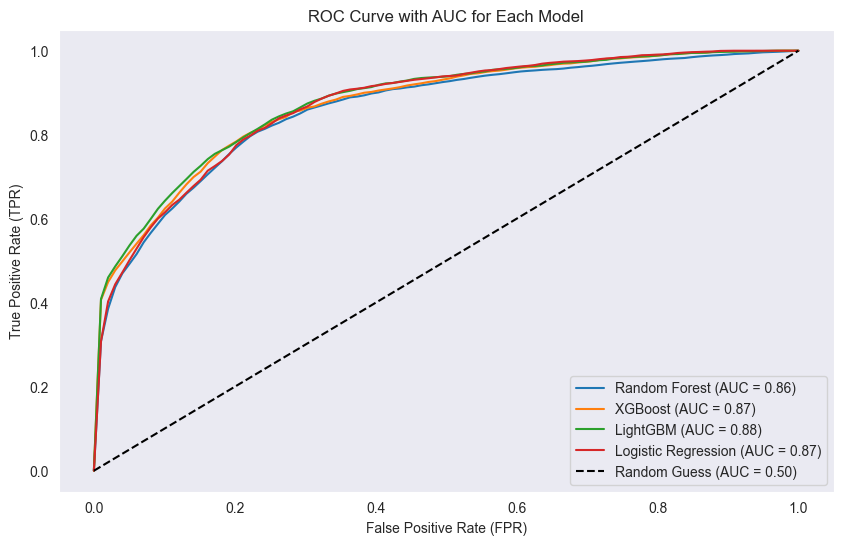

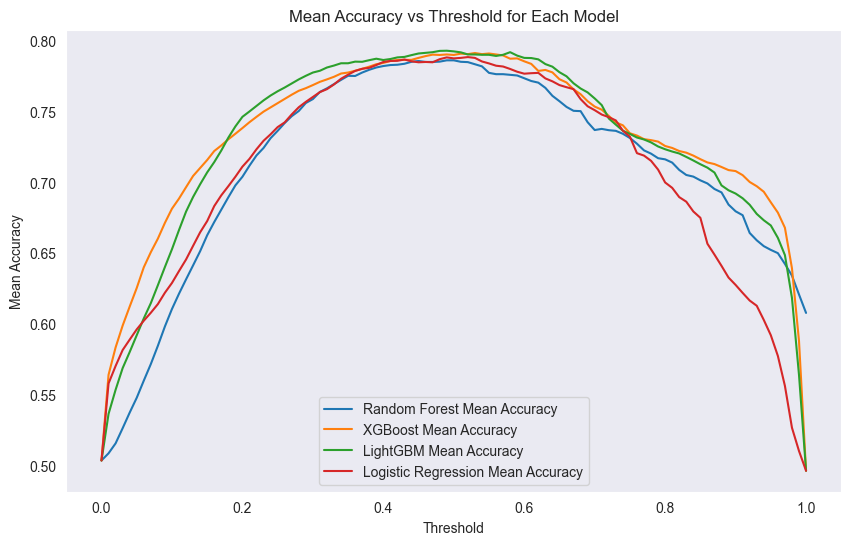

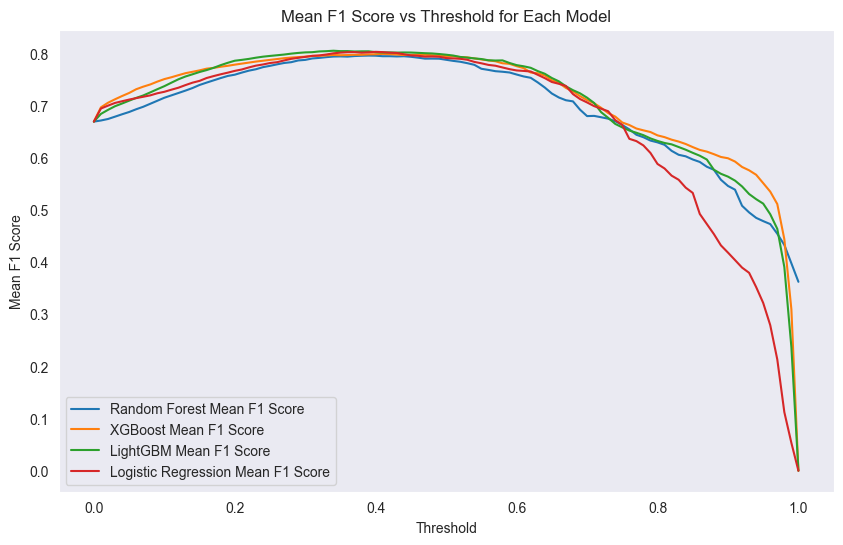

In [131]:
thresholds_range = np.linspace(0, 1, 101)

# Plotting AUC-ROC Curve for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    mean_fpr = metrics["mean_fpr"]
    mean_tpr = metrics["mean_tpr"]
    
    auc_score = np.trapz(mean_tpr, mean_fpr)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.50)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve with AUC for Each Model")
plt.legend()
plt.grid()
plt.show()


# Plotting Accuracy vs Threshold for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(thresholds_range, metrics["mean_accuracy"], label=f'{model_name} Mean Accuracy')

plt.xlabel("Threshold")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs Threshold for Each Model")
plt.legend()
plt.grid()
plt.show()

# Plotting F1 Score vs Threshold for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in model_results.items():
    plt.plot(thresholds_range, metrics["mean_f1"], label=f'{model_name} Mean F1 Score')

plt.xlabel("Threshold")
plt.ylabel("Mean F1 Score")
plt.title("Mean F1 Score vs Threshold for Each Model")
plt.legend()
plt.grid()
plt.show()

LightGBM has the best overall accuracy, AUC ROC, and F1 score for the 
validation set. <br>
The best threshold point, maximizing accuracy while balancing AUC and F1 
score, according to the graphs will be close to 0.5.

**Best Threshold for Chosen Model**

In [132]:
lightgbm_results = model_results["LightGBM"]

best_threshold_idx = np.argmax(lightgbm_results["mean_accuracy"])
best_threshold = thresholds_range[best_threshold_idx]
best_accuracy = lightgbm_results["mean_accuracy"][best_threshold_idx]
best_f1_at_best_threshold = lightgbm_results["mean_f1"][best_threshold_idx]

auc_roc = lightgbm_results["auc_score"]

print(f"Best Threshold for LightGBM (Max Accuracy): {best_threshold}")
print(f"Max Accuracy at Best Threshold: {best_accuracy}")
print(f"F1 Score at Best Threshold: {best_f1_at_best_threshold}")
print(f"AUC ROC for LightGBM: {auc_roc}")

Best Threshold for LightGBM (Max Accuracy): 0.49
Max Accuracy at Best Threshold: 0.7930540216292977
F1 Score at Best Threshold: 0.7995182698253981
AUC ROC for LightGBM: 0.877644173691631


Both F1 score and AUC ROC have improved significantly, compared to baseline 
model. However, Accuracy did not improve as much as expected.

## 6.3. Hyperparameter Tuning

**Run Optimization**

In [133]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameter search space for LightGBM within the pipeline
    param_grid = {
        "classifier__n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "classifier__learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "classifier__max_depth": trial.suggest_int("max_depth", 3, 12),
        "classifier__min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "classifier__subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "classifier__reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "classifier__reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
    }
    
    pipeline_lgb.set_params(**param_grid)
    
    cv_scores = cross_val_score(pipeline_lgb, X, y, cv=5, scoring="accuracy")
    
    return cv_scores.mean()


In [134]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers
                            .RandomSampler(seed=0))
study.optimize(objective, n_trials=50)

[I 2024-11-05 14:40:55,188] A new study created in memory with name: no-name-f3356a48-d3ad-4b2e-a387-6f472ab814e7
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:41:07,207] Trial 0 finished with value: 0.7913287598986495 and parameters: {'n_estimators': 1143, 'learning_rate': 0.013981961408994055, 'max_depth': 9, 'min_child_samples': 57, 'subsample': 0.7118273996694524, 'reg_alpha': 0.006502000785097662, 'reg_lambda': 8.675307976899775e-05}. Best is trial 0 with value: 0.7913287598986495.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:41:18,263] Trial 1 finished with value: 0.7814357020389877 and parameters: {'n_estimators': 1795, 'learning_rate': 0.07780155576901421, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.7644474598764522, 'reg_alpha': 0.001295391520396607, 'reg_lambda': 2.13978305808933}. Best is trial 0 with value: 0.7913287598986495.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:41:20,307] Trial 2 finished with value: 0.7166711553999462 and parameters: {'n_estimators': 235, 'learning_rate': 0.00018255254802399022, 'max_depth': 3, 'min_child_samples': 84, 'subsample': 0.8890783754749252, 'reg_alpha': 0.6762532016190338, 'reg_lambda': 6.42044426233932}. Best is trial 0 with value: 0.7913287598986495.


[LightGBM] [Info] Number of positive: 3503, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503666 -> initscore=0.014666
[LightGBM] [Info] Start training from score 0.014666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:41:39,926] Trial 3 finished with value: 0.7931679714873898 and parameters: {'n_estimators': 1619, 'learning_rate': 0.0024234724484675954, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.819960510663762, 'reg_alpha': 1.9506510537765813e-07, 'reg_lambda': 3.177022228527139}. Best is trial 3 with value: 0.7931679714873898.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264450

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:41:48,829] Trial 4 finished with value: 0.7869584982970386 and parameters: {'n_estimators': 1092, 'learning_rate': 0.0017538232373118048, 'max_depth': 5, 'min_child_samples': 79, 'subsample': 0.7280751661082743, 'reg_alpha': 0.001305886823451577, 'reg_lambda': 1.4760742495197955e-08}. Best is trial 3 with value: 0.7931679714873898.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:42:01,385] Trial 5 finished with value: 0.795815419758323 and parameters: {'n_estimators': 1274, 'learning_rate': 0.006859416411328701, 'max_depth': 9, 'min_child_samples': 95, 'subsample': 0.8409101495517417, 'reg_alpha': 1.7201689540343315e-05, 'reg_lambda': 8.5760555256054e-05}. Best is trial 5 with value: 0.795815419758323.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262644502

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:42:18,482] Trial 6 finished with value: 0.7823564989468572 and parameters: {'n_estimators': 1426, 'learning_rate': 0.0001515920461138471, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6051912805369204, 'reg_alpha': 1.4465607560792659e-07, 'reg_lambda': 6.900096401402642e-06}. Best is trial 5 with value: 0.795815419758323.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:42:26,840] Trial 7 finished with value: 0.794320638489774 and parameters: {'n_estimators': 791, 'learning_rate': 0.005135589606500232, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.551022405374014, 'reg_alpha': 7.583868689982382e-07, 'reg_lambda': 2.829994952731329e-07}. Best is trial 5 with value: 0.795815419758323.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:42:42,491] Trial 8 finished with value: 0.7851177647299382 and parameters: {'n_estimators': 1341, 'learning_rate': 0.000575274081411669, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5794847918227599, 'reg_alpha': 9.848640172873773e-08, 'reg_lambda': 0.008071724032088088}. Best is trial 5 with value: 0.795815419758323.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264450

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:42:46,890] Trial 9 finished with value: 0.7747644738487722 and parameters: {'n_estimators': 362, 'learning_rate': 0.0003888186473153669, 'max_depth': 6, 'min_child_samples': 83, 'subsample': 0.5485506378965306, 'reg_alpha': 0.34793984646334997, 'reg_lambda': 7.326316408987164e-08}. Best is trial 5 with value: 0.795815419758323.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:43:09,935] Trial 10 finished with value: 0.7985757591197935 and parameters: {'n_estimators': 1956, 'learning_rate': 0.002546558192892438, 'max_depth': 12, 'min_child_samples': 63, 'subsample': 0.8696317896991508, 'reg_alpha': 2.2526313830315164e-08, 'reg_lambda': 3.509640743717519e-06}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:43:12,824] Trial 11 finished with value: 0.7710843963469872 and parameters: {'n_estimators': 328, 'learning_rate': 0.0007734292502064652, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.707131497257335, 'reg_alpha': 3.778569956294474e-08, 'reg_lambda': 0.017070611332063324}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:43:26,813] Trial 12 finished with value: 0.7866134724200978 and parameters: {'n_estimators': 1177, 'learning_rate': 0.0006254152586876395, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.7879732477780896, 'reg_alpha': 2.3102861693191303, 'reg_lambda': 7.3641151715586195e-06}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:43:42,888] Trial 13 finished with value: 0.7862673877756021 and parameters: {'n_estimators': 1368, 'learning_rate': 0.00024853845095262005, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.5915956810035584, 'reg_alpha': 0.0018993999108802122, 'reg_lambda': 1.5169382966817724e-08}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:44:01,004] Trial 14 finished with value: 0.7785604202248425 and parameters: {'n_estimators': 1675, 'learning_rate': 0.00010329669551879738, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.8675970110612974, 'reg_alpha': 4.567692992421122, 'reg_lambda': 1.7329191127586087e-06}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:44:14,238] Trial 15 finished with value: 0.7905231701353437 and parameters: {'n_estimators': 1195, 'learning_rate': 0.005972082434777335, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.9763745057584925, 'reg_alpha': 0.00010571300239371601, 'reg_lambda': 0.4146465461659167}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:

[I 2024-11-05 14:44:31,352] Trial 16 finished with value: 0.7885693469587893 and parameters: {'n_estimators': 1429, 'learning_rate': 0.0007803884850277913, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.9405515985555808, 'reg_alpha': 0.0017039461034363888, 'reg_lambda': 0.8622203259760316}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:44:43,293] Trial 17 finished with value: 0.7935147840345793 and parameters: {'n_estimators': 1416, 'learning_rate': 0.01498866107685078, 'max_depth': 8, 'min_child_samples': 96, 'subsample': 0.8219950996148186, 'reg_alpha': 6.526726844028597e-05, 'reg_lambda': 0.0028677344079246886}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:44:46,222] Trial 18 finished with value: 0.7828170628332223 and parameters: {'n_estimators': 136, 'learning_rate': 0.0008030164648270109, 'max_depth': 9, 'min_child_samples': 32, 'subsample': 0.8090077144994208, 'reg_alpha': 7.226338622295001e-05, 'reg_lambda': 1.656786617749256e-07}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:44:54,587] Trial 19 finished with value: 0.7922495568065189 and parameters: {'n_estimators': 667, 'learning_rate': 0.005127370874628443, 'max_depth': 8, 'min_child_samples': 60, 'subsample': 0.8266004099285669, 'reg_alpha': 0.007394851038499022, 'reg_lambda': 7.634241934092264e-05}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262644

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:45:13,698] Trial 20 finished with value: 0.7914442979080738 and parameters: {'n_estimators': 1804, 'learning_rate': 0.001266734532833683, 'max_depth': 7, 'min_child_samples': 90, 'subsample': 0.9030969945230429, 'reg_alpha': 0.02162704838479807, 'reg_lambda': 7.980718378532859e-08}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:45:35,557] Trial 21 finished with value: 0.7912144791756965 and parameters: {'n_estimators': 1847, 'learning_rate': 0.013890692540260638, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.9340630286841072, 'reg_alpha': 2.9002565219638275e-07, 'reg_lambda': 0.0034676565644602996}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:45:40,395] Trial 22 finished with value: 0.7942047696154887 and parameters: {'n_estimators': 335, 'learning_rate': 0.0349965060627184, 'max_depth': 11, 'min_child_samples': 59, 'subsample': 0.7035916486129998, 'reg_alpha': 4.192788534610656e-08, 'reg_lambda': 0.018917291599411426}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:45:50,566] Trial 23 finished with value: 0.7900632679787003 and parameters: {'n_estimators': 962, 'learning_rate': 0.014661108184060872, 'max_depth': 11, 'min_child_samples': 98, 'subsample': 0.9279016711963055, 'reg_alpha': 1.2747550985628033e-08, 'reg_lambda': 1.737011046336311e-05}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:46:08,490] Trial 24 finished with value: 0.7875335414252731 and parameters: {'n_estimators': 1487, 'learning_rate': 0.0003272570655120272, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.5999982624482001, 'reg_alpha': 1.4678989172825453e-08, 'reg_lambda': 0.13908469107223914}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:46:15,698] Trial 25 finished with value: 0.7891434636654135 and parameters: {'n_estimators': 525, 'learning_rate': 0.0010865633249460473, 'max_depth': 12, 'min_child_samples': 72, 'subsample': 0.515919464765654, 'reg_alpha': 3.0356200209294054e-07, 'reg_lambda': 0.003920176433086229}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:46:30,714] Trial 26 finished with value: 0.7902937484407992 and parameters: {'n_estimators': 1197, 'learning_rate': 0.0005172237564581172, 'max_depth': 12, 'min_child_samples': 63, 'subsample': 0.7678164015124791, 'reg_alpha': 0.0020379324619861656, 'reg_lambda': 0.03724759750057168}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:46:37,616] Trial 27 finished with value: 0.7848881445164774 and parameters: {'n_estimators': 693, 'learning_rate': 0.001565536460836166, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.9721861949919668, 'reg_alpha': 0.04528529022952061, 'reg_lambda': 0.00025949516931228906}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:46:40,468] Trial 28 finished with value: 0.752332167144987 and parameters: {'n_estimators': 532, 'learning_rate': 0.0005795213566496783, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.6558979409970513, 'reg_alpha': 0.01849657847309738, 'reg_lambda': 2.5105365797045206e-05}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:46:43,033] Trial 29 finished with value: 0.7248404073343477 and parameters: {'n_estimators': 441, 'learning_rate': 0.00011858675498738619, 'max_depth': 3, 'min_child_samples': 70, 'subsample': 0.7268484222780227, 'reg_alpha': 0.0006748587761045162, 'reg_lambda': 1.1750102019641628}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:47:05,916] Trial 30 finished with value: 0.7860377675621413 and parameters: {'n_estimators': 1982, 'learning_rate': 0.00044739482178027853, 'max_depth': 9, 'min_child_samples': 30, 'subsample': 0.5103254997328643, 'reg_alpha': 0.06689719135662117, 'reg_lambda': 7.588472373889296e-06}. Best is trial 10 with value: 0.7985757591197935.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:47:16,229] Trial 31 finished with value: 0.7940899595087583 and parameters: {'n_estimators': 828, 'learning_rate': 0.005820380012591099, 'max_depth': 11, 'min_child_samples': 65, 'subsample': 0.9363253277236976, 'reg_alpha': 2.89653188346016e-06, 'reg_lambda': 0.15220240159882986}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:47:22,038] Trial 32 finished with value: 0.7898341109760446 and parameters: {'n_estimators': 452, 'learning_rate': 0.07217303539978494, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.9736852952444621, 'reg_alpha': 0.037818322492277276, 'reg_lambda': 1.9296332917314344e-06}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:47:24,811] Trial 33 finished with value: 0.7779859064803853 and parameters: {'n_estimators': 505, 'learning_rate': 0.0035859327597232275, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7123427343757531, 'reg_alpha': 2.330933175000022e-05, 'reg_lambda': 0.0001486547597235943}. Best is trial 10 with value: 0.7985757591197935.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:47:33,195] Trial 34 finished with value: 0.8008768580543426 and parameters: {'n_estimators': 627, 'learning_rate': 0.005759079044844155, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.758689553577057, 'reg_alpha': 1.5438779234885336e-07, 'reg_lambda': 0.028296787326479306}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26264

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:47:38,303] Trial 35 finished with value: 0.7920190101714477 and parameters: {'n_estimators': 852, 'learning_rate': 0.004968942092731393, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7440281403244773, 'reg_alpha': 1.586772410276577e-05, 'reg_lambda': 2.909963269906004}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:47:57,232] Trial 36 finished with value: 0.7912128910243642 and parameters: {'n_estimators': 1554, 'learning_rate': 0.017619389630908606, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.7760962349612033, 'reg_alpha': 0.0018208938143730203, 'reg_lambda': 4.543885790233345}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:48:01,778] Trial 37 finished with value: 0.7738442724976525 and parameters: {'n_estimators': 655, 'learning_rate': 0.000527820604505841, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.9647646583960953, 'reg_alpha': 0.010696677921155886, 'reg_lambda': 0.1165134892128684}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2024-11-05 14:48:04,816] Trial 38 finished with value: 0.7863828596120543 and parameters: {'n_estimators': 635, 'learning_rate': 0.00574421251115168, 'max_depth': 3, 'min_child_samples': 51, 'subsample': 0.9887475698722235, 'reg_alpha': 0.7736547705477379, 'reg_lambda': 1.1051737639783883e-05}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:48:27,936] Trial 39 finished with value: 0.789373679435624 and parameters: {'n_estimators': 1927, 'learning_rate': 0.0004955698533896731, 'max_depth': 12, 'min_child_samples': 95, 'subsample': 0.8996012936761959, 'reg_alpha': 0.0047209720777778436, 'reg_lambda': 0.7389102646094704}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262644

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:48:36,317] Trial 40 finished with value: 0.8004158309571722 and parameters: {'n_estimators': 657, 'learning_rate': 0.035223350627705416, 'max_depth': 9, 'min_child_samples': 6, 'subsample': 0.6736167589661097, 'reg_alpha': 2.1541093635418752e-07, 'reg_lambda': 6.862217963513888}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:48:48,555] Trial 41 finished with value: 0.7947802097815564 and parameters: {'n_estimators': 1009, 'learning_rate': 0.0031058043686105568, 'max_depth': 9, 'min_child_samples': 40, 'subsample': 0.5684501358427995, 'reg_alpha': 0.2506453192984254, 'reg_lambda': 5.112475115411947e-07}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262644

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:48:53,096] Trial 42 finished with value: 0.7554375985563704 and parameters: {'n_estimators': 1072, 'learning_rate': 0.00047092428484708175, 'max_depth': 3, 'min_child_samples': 87, 'subsample': 0.9864597445115652, 'reg_alpha': 4.441318538278994, 'reg_lambda': 1.4421136679538653}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262644502

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:48:58,652] Trial 43 finished with value: 0.7757990220958172 and parameters: {'n_estimators': 1571, 'learning_rate': 0.0009987009341166668, 'max_depth': 3, 'min_child_samples': 44, 'subsample': 0.6161170710854713, 'reg_alpha': 1.5573589132823735e-07, 'reg_lambda': 3.025830777863833e-08}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/26

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:49:16,344] Trial 44 finished with value: 0.7809761969201776 and parameters: {'n_estimators': 1479, 'learning_rate': 0.00010821373223234175, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.5397610412933779, 'reg_alpha': 6.40364588901408e-08, 'reg_lambda': 0.011179702998691652}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:49:23,390] Trial 45 finished with value: 0.7893739441275127 and parameters: {'n_estimators': 566, 'learning_rate': 0.0018264946314358692, 'max_depth': 8, 'min_child_samples': 87, 'subsample': 0.8635221313556641, 'reg_alpha': 2.7098867854132046e-06, 'reg_lambda': 1.525264609908988e-07}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/262

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:49:26,276] Trial 46 finished with value: 0.775454591775626 and parameters: {'n_estimators': 205, 'learning_rate': 0.0008031485940500918, 'max_depth': 5, 'min_child_samples': 48, 'subsample': 0.8416406677738402, 'reg_alpha': 0.01822338333293153, 'reg_lambda': 3.561800735365044e-06}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:12: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:

[I 2024-11-05 14:49:36,773] Trial 47 finished with value: 0.7845430524665644 and parameters: {'n_estimators': 822, 'learning_rate': 0.0003495045912526376, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8484986208624936, 'reg_alpha': 0.10191980016561582, 'reg_lambda': 0.09923572721953104}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] 

[I 2024-11-05 14:49:44,169] Trial 48 finished with value: 0.7853481128460928 and parameters: {'n_estimators': 593, 'learning_rate': 0.001322633181347478, 'max_depth': 8, 'min_child_samples': 31, 'subsample': 0.6854263996089444, 'reg_alpha': 5.935926594310808e-07, 'reg_lambda': 0.00013762678152982237}. Best is trial 34 with value: 0.8008768580543426.
/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626445021.py:11: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/vg/22myvdm92t917z8pt81n0xnh0000gn/T/ipykernel_41715/2626

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2024-11-05 14:49:46,013] Trial 49 finished with value: 0.7904094849691402 and parameters: {'n_estimators': 184, 'learning_rate': 0.025083472189932864, 'max_depth': 3, 'min_child_samples': 54, 'subsample': 0.6534050497725981, 'reg_alpha': 0.0015771991686501633, 'reg_lambda': 4.314197943808931}. Best is trial 34 with value: 0.8008768580543426.


[LightGBM] [Info] Number of positive: 3503, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503666 -> initscore=0.014666
[LightGBM] [Info] Start training from score 0.014666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

**Visualization**

In [135]:
optuna.visualization.plot_optimization_history(study)

Accuracy was optimized on the 34th trial, without much or any improvement for
 the following trials.

In [136]:
optuna.visualization.plot_slice(study, params=[
    'n_estimators', 
    'learning_rate', 
    'max_depth', 
    'min_child_samples', 
    'subsample', 
    'reg_alpha', 
    'reg_lambda'
])

min_child_samples, n_estimators, re_alpha, reg_lambda, and subsample didn't 
show much influence to our accuracy.

## 6.4. Final Model

**Complete pipeline**

In [137]:
spaceship_copy = spaceship_train.copy()

target_name = 'Transported'
X, y = (spaceship_copy.drop(columns=[target_name]), 
                spaceship_copy[target_name])

One step is still missing in the pipeline, the step of creating new features
 that was done in part 2.4 of this notebook.

In [138]:
pipeline_lgb = Pipeline(steps=[
    ('group_features', GroupFeaturesTransformer()), 
    ('preprocessor', preprocessor_1),         
    ('feature_selection', feature_selector),       
    ('classifier', clf_lgb)                        
])

Now fitting the whole train data for final prediction

In [139]:
best_params = study.best_params

pipeline_lgb.set_params(**{f"classifier__{k}": v for k, v in best_params.items()})
final_pipeline_lgb = pipeline_lgb.fit(X, y)
final_pipeline_lgb

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


Pipeline(steps=[('group_features', GroupFeaturesTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('...
                                                   'Deck'])])),
                ('feature_selection',
                 SelectKBest(k=14,
                             score_func=<function mutual_info_classif at 0x1658510d0>)),
                ('classifier',
                 LGBMClassifier(learning_rate=0.005759079044844155,
                                max_depth=11, min_child_samples=16,
                                n_estimators=627, objective='binary',
                                random_state=0,
                                reg_alpha=1.5438779234885336e-07,
                                reg_lambda=0.028296787326479306,
                                subsample=0.758689553577057))])

**Test Data**

In [140]:
X_test = pd.read_csv('data/test.csv')
spaceship_test_shape = X_test.shape
print(f"Number of rows on test data: {spaceship_test_shape[0]}\nNumber of "
      f"columns on test data: {spaceship_test_shape[1]}")

Number of rows on test data: 4277
Number of columns on test data: 13


In [141]:
y_proba_new = final_pipeline_lgb.predict_proba(X_test)[:, 1]
y_pred_new = (y_proba_new >= best_threshold).astype(int)

transported = pd.Series(y_pred_new).map({1: 'True', 0: 'False'})

submission = pd.DataFrame({
    "PassengerId": X_test["PassengerId"],
    "Transported": transported
})

submission.to_csv("submission.csv", index=False)
print("Submission file created successfully.")

Submission file created successfully.


In [142]:
submission = pd.read_csv("submission.csv")
submission.shape

(4277, 2)

**Kaggle submission result: 0.79962**

## 6.5. Deployment

In [143]:
filename = 'spaceship_titanic.pkl'
with open(filename, 'wb') as f:
    pickle.dump(final_pipeline_lgb, f)

## 6.6. Model Interpretation

In [144]:
selected_mask = final_pipeline_lgb.named_steps['feature_selection'].get_support()
all_transformed_feature_names = final_pipeline_lgb.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = all_transformed_feature_names[selected_mask]

print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['num__Age' 'num__RoomService' 'num__FoodCourt' 'num__ShoppingMall'
 'num__Spa' 'num__VRDeck' 'ord__CryoSleep' 'ord__VIP' 'ord__InGroup'
 'ord__Side' 'cat__HomePlanet_Earth' 'cat__HomePlanet_Europa'
 'cat__Deck_B' 'cat__Deck_C']


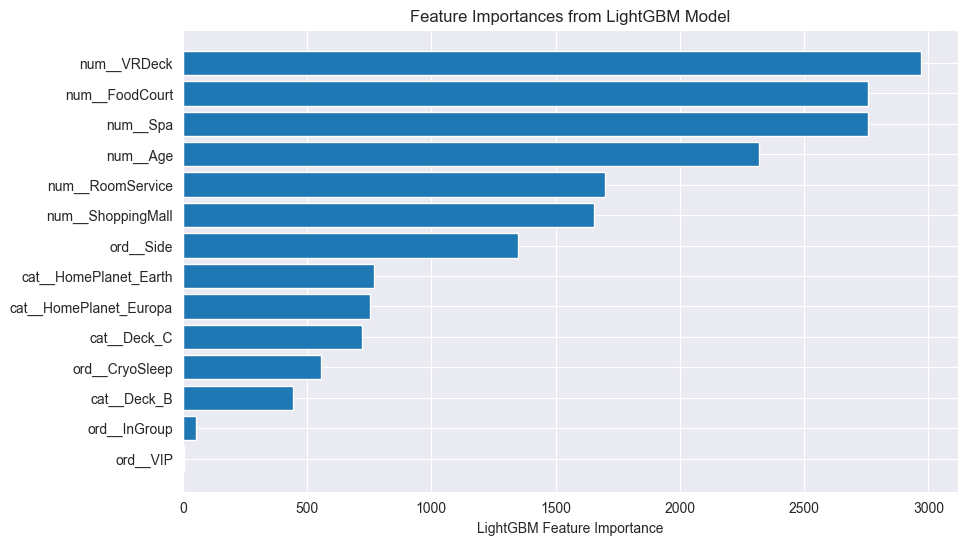

In [145]:
final_model = final_pipeline_lgb.named_steps['classifier']
sorted_idx = final_model.feature_importances_.argsort()

plt.figure(figsize=(10, 6))
plt.barh([selected_feature_names[i] for i in sorted_idx], final_model.feature_importances_[sorted_idx])
plt.xlabel('LightGBM Feature Importance')
plt.title('Feature Importances from LightGBM Model')
plt.show()

/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.3.5/.venv/lib/python3.9/site-packages/shap/explainers/_tree.py:382: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



/Users/celineng/PycharmProjects/chilng-DS.v2.5.3.3.5/.venv/lib/python3.9/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



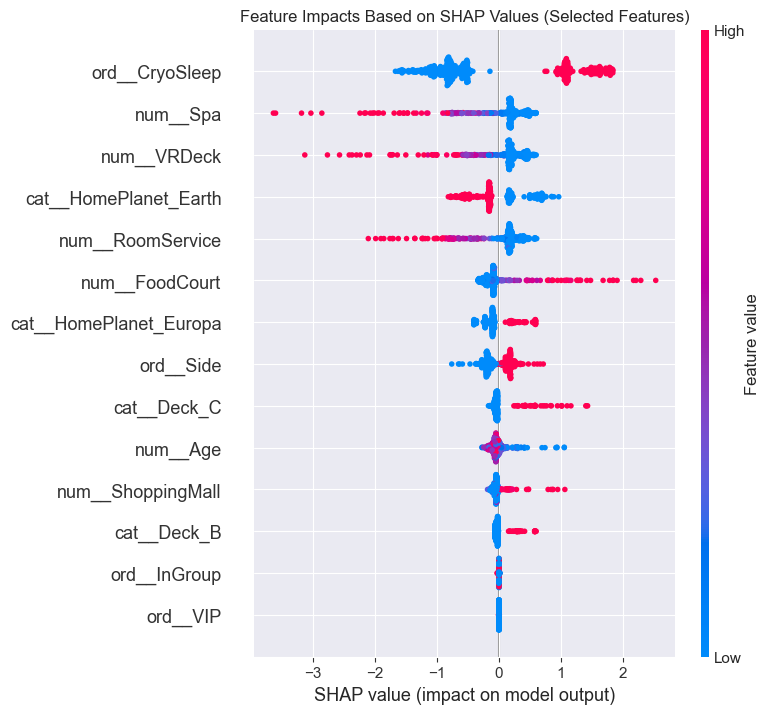

In [146]:
X_transformed = final_pipeline_lgb[:-1].transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=selected_feature_names)
observations = X_transformed_df.sample(500, random_state=0)
explainer = shap.TreeExplainer(final_model)
shap_vals = explainer.shap_values(observations)

shap.initjs()
shap.summary_plot(shap_vals[1], observations, 
                  feature_names=selected_feature_names, show=False)
plt.title("Feature Impacts Based on SHAP Values (Selected Features)")
plt.show()

The features listed both on feature importance and SHAP are congruent with 
EDA analysis. However, the order and strength shown on Feature Importance was
 surprising. 
<br><br>
**SHAP and Feature Importance** <br>
As EDA showed us, CryoSleep followed by luxury amenities have
huge distinction between the 2 classes in SHAP. But in feature importance, 
these follow an opposite order. This maybe that CryoSleep is not important 
for splits in the decision tree, but is critical in specific context. 
CryoSleep is correlated with several other features, possibly CryoSleep are 
affected by those.<br>
It was also surprising to see Age, that were not given much  
attention/important, is high on feature importance.

# Improvements & Conclusion

This is the first iteration of this project, with submission score 0.79962. 
A part of the project, which is not seen, is that LabelEncoder was first 
used, but changed to OrdinalEncoder after hyperparameter tuning proved 
the latter better, by a few percent.<br>
For the second iteration, I would spend more time on the following 
improvements:<br>

1. More thorough EDA and feature extraction/creation, because the final model 
interpretation had a few surprising details. For example, luxury amenities 
features can create a 'Total Spending' feature, which might have more impact.
2. Deeper analysis of encoding and imputation methods.
3. Try if PCA or Boruta would provide better feature selection.
4. Try CatBoost as the data has quite some categorical features, and other 
models.
5. Divide dataset into one more set for a final evaluation before submission.